Working in the healthcare field means working with endless acronyms and abbreviations. It can be difficult to understand what you’re reading. By gathering and analyzing medical and gene abbreviations from NCBI and Wikipedia I want to show the best way to make a life sciences acronym translator. I'd like to be able to input an acronym and its paragraph and output a definition. I believe that that niche technical terms for a specific field will define an acronym better than the defining characteristics of the specific acronym. To decide between 2 acronym definitions from 2 different fields, all you need to do is to determine the correct field. 

From NCBI I have gathered technical gene acronym definitions as well as abstracts which explain medical information about specific genes. Some of the gene abstracts and definitions have acronyms that match or partially match with the abbreviations in a list of medical abbreviations I gathered from Wikipedia, although the meanings may be different. I plan to create a dataframe with a column of tokenized strings. Another column will show which dataset a particular string came from. I will turn these strings into a Levenshtein distances matrix. Calculating Levenshtein distances is a good way to tell how similar 2 strings of different lengths are. I will then cluster the Levenshtein distances using Affinity Propogation, and Spectral Clustering, both of which can take precomputed affinities. Hopefully I will see the abstracts being clustered with both the gene and medical data, but I will not see the gene and medical data clustered together very much. The gene definitions and gene abstracts share a lot of language so I expect to see these clustered together the most.

In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import AffinityPropagation as Aff
import numpy as np
import distance

import matplotlib.pyplot as plt

%matplotlib inline
import Levenshtein as lev
import editdistance as ed
import seaborn as sns

First I'll import and clean the datasets.

In [3]:
# import abstracts data (from genes database) and label it so I can find it when it's mixed in
abstracts= pd.read_csv('genesdf')
abstracts.head()
abstracts['abstract'] = 1
abstracts['med']=0

In [4]:
#import medical data (already labeled)
meddf = pd.read_csv('meddf')
meddf.head()

,Unnamed: 0,acro,med,blurb2
0,0,ā,1,ā is (a with a bar over it) before (from Lat...
1,1,A,1,A is assessment
2,2,ap,1,ap is apical
3,3,a.a.,1,a.a. is of each (from Latin ana ana) ami...
4,4,A1C,1,A1C is glycosylated hemoglobin (hemoglobi...


In [5]:
# import genes data and label it not medical. Remove duplicates.
genes = pd.read_csv('genesdf2')
genes['med']=0
genes = genes[genes.duplicated(subset=None, keep='first')==0]
genes.head()

,Unnamed: 0,acros,blurb2,match,med
0,0,TP53,Official Symbol- TP53 and Name: tumor protein ...,0,0
1,1,EGFR,Official Symbol- EGFR and Name: epidermal grow...,0,0
2,2,TNF,Official Symbol- TNF and Name: tumor necrosis ...,0,0
3,3,APOE,Official Symbol- APOE and Name: apolipoprotein...,0,0
4,4,VEGFA,Official Symbol- VEGFA and Name: vascular endo...,0,0


In [6]:
#clean medical acronyms column
meddf['symbols'] = meddf['acro'].apply(lambda x: (str(x).upper()).strip())
meddf = meddf.drop(columns =['acro'])

In [7]:
#clean genes acronyms column
genes['symbols'] = genes['acros'].apply(lambda x: (str(x).upper()).strip())
genes = genes.drop(columns =['acros'])

In [8]:
#clean abstracts acronyms column
abstracts['symbols'] = abstracts['symbol'].apply(lambda x: (str(x).upper()).strip())
abstracts = abstracts.drop(columns =['symbol'])

In [9]:
#combine abstracts with acronyms
abstracts['blurbs'] = abstracts['symbols']+','+abstracts['blurb']
abstracts.head()

,Unnamed: 0,blurb,match,abstract,med,symbols,blurbs
0,0,This gene encodes a tumor suppressor protein c...,0,1,0,TP53,"TP53,This gene encodes a tumor suppressor prot..."
1,1,The protein encoded by this gene is a transmem...,0,1,0,EGFR,"EGFR,The protein encoded by this gene is a tra..."
2,2,This gene encodes a multifunctional proinflamm...,0,1,0,TNF,"TNF,This gene encodes a multifunctional proinf..."
3,3,The protein encoded by this gene is a major ap...,0,1,0,APOE,"APOE,The protein encoded by this gene is a maj..."
4,4,This gene is a member of the PDGF/VEGF growth ...,0,1,0,VEGFA,"VEGFA,This gene is a member of the PDGF/VEGF g..."


In [10]:
abstracts['blurbs2'] = abstracts['blurbs'].apply(lambda x: str(x).split(',',1))
abstracts.head()

,Unnamed: 0,blurb,match,abstract,med,symbols,blurbs,blurbs2
0,0,This gene encodes a tumor suppressor protein c...,0,1,0,TP53,"TP53,This gene encodes a tumor suppressor prot...","[TP53, This gene encodes a tumor suppressor pr..."
1,1,The protein encoded by this gene is a transmem...,0,1,0,EGFR,"EGFR,The protein encoded by this gene is a tra...","[EGFR, The protein encoded by this gene is a t..."
2,2,This gene encodes a multifunctional proinflamm...,0,1,0,TNF,"TNF,This gene encodes a multifunctional proinf...","[TNF, This gene encodes a multifunctional proi..."
3,3,The protein encoded by this gene is a major ap...,0,1,0,APOE,"APOE,The protein encoded by this gene is a maj...","[APOE, The protein encoded by this gene is a m..."
4,4,This gene is a member of the PDGF/VEGF growth ...,0,1,0,VEGFA,"VEGFA,This gene is a member of the PDGF/VEGF g...","[VEGFA, This gene is a member of the PDGF/VEGF..."


In [11]:
def add_symbol(words_list,replace,texts):
    for words in words_list:
        new = texts.replace(words,replace)
        texts = new
    return texts
   

In [12]:
abstracts['blurbs3'] = abstracts['blurbs2'].apply(lambda x: add_symbol(['This gene','this gene'],x[0]+' gene',x[1]) if len(x)==2 else np.nan)

In [13]:
abstracts.head()

,Unnamed: 0,blurb,match,abstract,med,symbols,blurbs,blurbs2,blurbs3
0,0,This gene encodes a tumor suppressor protein c...,0,1,0,TP53,"TP53,This gene encodes a tumor suppressor prot...","[TP53, This gene encodes a tumor suppressor pr...",TP53 gene encodes a tumor suppressor protein c...
1,1,The protein encoded by this gene is a transmem...,0,1,0,EGFR,"EGFR,The protein encoded by this gene is a tra...","[EGFR, The protein encoded by this gene is a t...",The protein encoded by EGFR gene is a transmem...
2,2,This gene encodes a multifunctional proinflamm...,0,1,0,TNF,"TNF,This gene encodes a multifunctional proinf...","[TNF, This gene encodes a multifunctional proi...",TNF gene encodes a multifunctional proinflamma...
3,3,The protein encoded by this gene is a major ap...,0,1,0,APOE,"APOE,The protein encoded by this gene is a maj...","[APOE, The protein encoded by this gene is a m...",The protein encoded by APOE gene is a major ap...
4,4,This gene is a member of the PDGF/VEGF growth ...,0,1,0,VEGFA,"VEGFA,This gene is a member of the PDGF/VEGF g...","[VEGFA, This gene is a member of the PDGF/VEGF...",VEGFA gene is a member of the PDGF/VEGF growth...


In [14]:
#prepare to combine 3 datasets
abstracts = abstracts.drop(columns = ['blurb','blurbs','blurbs2'])
abstracts.head()

,Unnamed: 0,match,abstract,med,symbols,blurbs3
0,0,0,1,0,TP53,TP53 gene encodes a tumor suppressor protein c...
1,1,0,1,0,EGFR,The protein encoded by EGFR gene is a transmem...
2,2,0,1,0,TNF,TNF gene encodes a multifunctional proinflamma...
3,3,0,1,0,APOE,The protein encoded by APOE gene is a major ap...
4,4,0,1,0,VEGFA,VEGFA gene is a member of the PDGF/VEGF growth...


In [15]:
abstracts = abstracts.rename(columns ={'blurbs3':'blurb2'})
abstracts.head()

,Unnamed: 0,match,abstract,med,symbols,blurb2
0,0,0,1,0,TP53,TP53 gene encodes a tumor suppressor protein c...
1,1,0,1,0,EGFR,The protein encoded by EGFR gene is a transmem...
2,2,0,1,0,TNF,TNF gene encodes a multifunctional proinflamma...
3,3,0,1,0,APOE,The protein encoded by APOE gene is a major ap...
4,4,0,1,0,VEGFA,VEGFA gene is a member of the PDGF/VEGF growth...


Next I'll combine all 3 datasets.

In [16]:
#combine datasets
genesdf = genes.append(abstracts,ignore_index = True)
genesdf = genesdf.append(meddf,ignore_index = True)
genesdf = genesdf.drop(columns = ['Unnamed: 0'])
genesdf.head()

,abstract,blurb2,match,med,symbols
0,NaN,Official Symbol- TP53 and Name: tumor protein ...,0.0,0,TP53
1,NaN,Official Symbol- EGFR and Name: epidermal grow...,0.0,0,EGFR
2,NaN,Official Symbol- TNF and Name: tumor necrosis ...,0.0,0,TNF
3,NaN,Official Symbol- APOE and Name: apolipoprotein...,0.0,0,APOE
4,NaN,Official Symbol- VEGFA and Name: vascular endo...,0.0,0,VEGFA


In [17]:
#clean genes definitions 
genesdf['blurb3'] = genesdf['blurb2'].apply(lambda x: str(x).replace('Official Symbol-',''))

In [18]:
genesdf['blurb4'] = genesdf['blurb3'].apply(lambda x: str(x).replace('and Name:','is'))

In [19]:
genesdf['blurb5'] = genesdf['blurb4'].apply(lambda x: str(x).replace('Other Aliases:','also'))

In [20]:
genesdf['blurb6'] = genesdf['blurb5'].apply(lambda x: str(x).replace('Other Designations:','It is'))

In [21]:
genesdf['blurb7'] = genesdf['blurb6'].apply(lambda x: str(x).replace('[Homo sapiens (human)]','(human)'))

In [22]:
genesdf['blurb8'] = genesdf['blurb7'].apply(lambda x: str(x).replace('Other Aliases-','and'))

In [23]:
genesdf = genesdf.drop(columns = ['blurb2','blurb3','blurb4','blurb5','blurb6','blurb7'])

In [24]:
genesdf.head()

,abstract,match,med,symbols,blurb8
0,NaN,0.0,0,TP53,"TP53 is tumor protein p53 (human),also BCC7, ..."
1,NaN,0.0,0,EGFR,EGFR is epidermal growth factor receptor (hum...
2,NaN,0.0,0,TNF,"TNF is tumor necrosis factor (human),also DIF..."
3,NaN,0.0,0,APOE,"APOE is apolipoprotein E (human),also AD2, AP..."
4,NaN,0.0,0,VEGFA,VEGFA is vascular endothelial growth factor A...


I'll tokenize all of the strings and get lemmas using Spacy.

In [25]:
#tokenize and get lemmas
import spacy
nlp = spacy.load('en',parser=False, entity=False,tagger=False,textcat=False,ner=False)
def token_filter(token): 
        return not (token.is_punct | token.is_space | token.is_stop | len(token.text)<= 3 and token.is_lower)

In [26]:
genesdf['tokens'] = genesdf['blurb8'].apply(lambda x: nlp(x))

In [27]:
genesdf['lemmas'] = genesdf['tokens'].apply(lambda x: [token.lemma_ for token in x if token_filter(token)])

In [28]:
genesdf['lemmastr'] = genesdf['lemmas'].apply(lambda x: ','.join([str(token) for token in x]))

In [29]:
genesdf.head()

,abstract,match,med,symbols,blurb8,tokens,lemmas,lemmastr
0,NaN,0.0,0,TP53,"TP53 is tumor protein p53 (human),also BCC7, ...","( , TP53, is, tumor, protein, p53, (, human),a...","[ , tp53, tumor, protein, (, human),also, bcc7...",",tp53,tumor,protein,(,human),also,bcc7,,,lfs1..."
1,NaN,0.0,0,EGFR,EGFR is epidermal growth factor receptor (hum...,"( , EGFR, is, epidermal, growth, factor, recep...","[ , egfr, epidermal, growth, factor, receptor,...",",egfr,epidermal,growth,factor,receptor,(,huma..."
2,NaN,0.0,0,TNF,"TNF is tumor necrosis factor (human),also DIF...","( , TNF, is, tumor, necrosis, factor, (, human...","[ , tnf, tumor, necrosis, factor, (, human),al...",",tnf,tumor,necrosis,factor,(,human),also,dif,..."
3,NaN,0.0,0,APOE,"APOE is apolipoprotein E (human),also AD2, AP...","( , APOE, is, apolipoprotein, E, (, human),als...","[ , apoe, apolipoprotein, e, (, human),also, a...",",apoe,apolipoprotein,e,(,human),also,ad2,,,ap..."
4,NaN,0.0,0,VEGFA,VEGFA is vascular endothelial growth factor A...,"( , VEGFA, is, vascular, endothelial, growth, ...","[ , vegfa, vascular, endothelial, growth, fact...",",vegfa,vascular,endothelial,growth,factor,a,(..."


In [30]:
genes_match = genesdf[genesdf['match']==1]

In [31]:
genes_no = genesdf[genesdf['match']==0]

In [32]:
genes_med = genesdf[genesdf['med']==1]

I'll prepare the training and test sets, making sure that there are  matching gene definitions, and gene abstracts in each set. The medical data is what I'm trying to match so I'll put all of it into both sets.  I will set aside 20% of the matching and unmatching gene definitions and abstracts for testing, so it will end up being heavier in medical data than the training set.

In [33]:
#prepare train and test sets
msk = np.random.rand(len(genes_match)) < 0.8
trainM = genes_match[msk]
testM = genes_match[~msk]
trainM.shape

(493, 8)

In [34]:
msk = np.random.rand(len(genes_no)) < 0.8
train1 = genes_no[msk]
test = genes_no[~msk]

test.head()

,abstract,match,med,symbols,blurb8,tokens,lemmas,lemmastr
1,NaN,0.0,0,EGFR,EGFR is epidermal growth factor receptor (hum...,"( , EGFR, is, epidermal, growth, factor, recep...","[ , egfr, epidermal, growth, factor, receptor,...",",egfr,epidermal,growth,factor,receptor,(,huma..."
4,NaN,0.0,0,VEGFA,VEGFA is vascular endothelial growth factor A...,"( , VEGFA, is, vascular, endothelial, growth, ...","[ , vegfa, vascular, endothelial, growth, fact...",",vegfa,vascular,endothelial,growth,factor,a,(..."
8,NaN,0.0,0,ERBB2,ERBB2 is erb-b2 receptor tyrosine kinase 2 (h...,"( , ERBB2, is, erb, -, b2, receptor, tyrosine,...","[ , erbb2, -, receptor, tyrosine, kinase, 2, (...",",erbb2,-,receptor,tyrosine,kinase,2,(,human),..."
22,NaN,0.0,0,AKT1,AKT1 is AKT serine/threonine kinase 1 (human)...,"( , AKT1, is, AKT, serine, /, threonine, kinas...","[ , akt1, akt, serine, /, threonine, kinase, 1...",",akt1,akt,serine,/,threonine,kinase,1,(,human..."
25,NaN,0.0,0,BDNF,BDNF is brain derived neurotrophic factor (hu...,"( , BDNF, is, brain, derived, neurotrophic, fa...","[ , bdnf, brain, derive, neurotrophic, factor,...",",bdnf,brain,derive,neurotrophic,factor,(,huma..."


In [35]:
msk = np.random.rand(len(genes_med)) < 0.8
trainMed = genes_med[msk]
testMed = genes_med[~msk]
trainMed.shape

(1846, 8)

In [36]:
train = train1.append(trainM,ignore_index = True)
train = train.append(trainMed,ignore_index = True)
#train.to_csv('traindf')

#train.shape

In [37]:
train=pd.read_csv('traindf')

In [38]:
train.shape

(5523, 9)

In [39]:
#prepare categories for analysis
train['abstracts'] = train['abstract'].fillna(0)
train['meds']=train['med'].fillna(0) 

In [40]:
train['abstracts2'] =  train['abstracts'].apply(lambda x: int(x)*'k')
train['meds2'] =  train['meds'].apply(lambda x: int(x)*'m')
train['sets'] = train['abstracts2']+train['meds2']
train['sets2'] = train['sets'].replace('','g')
train['sets2'].value_counts()
train = train.drop(columns=['abstract','med','sets'])
train.head()

,Unnamed: 0,match,symbols,blurb8,tokens,lemmas,lemmastr,abstracts,meds,abstracts2,meds2,sets2
0,0,0.0,TP53,"TP53 is tumor protein p53 (human),also BCC7, ...","TP53 is tumor protein p53 (human),also BCC7, ...","[' ', 'tp53', 'tumor', 'protein', '(', 'human)...",",tp53,tumor,protein,(,human),also,bcc7,,,lfs1...",0.0,0,,,g
1,1,0.0,EGFR,EGFR is epidermal growth factor receptor (hum...,EGFR is epidermal growth factor receptor (hum...,"[' ', 'egfr', 'epidermal', 'growth', 'factor',...",",egfr,epidermal,growth,factor,receptor,(,huma...",0.0,0,,,g
2,2,0.0,TNF,"TNF is tumor necrosis factor (human),also DIF...","TNF is tumor necrosis factor (human),also DIF...","[' ', 'tnf', 'tumor', 'necrosis', 'factor', '(...",",tnf,tumor,necrosis,factor,(,human),also,dif,...",0.0,0,,,g
3,3,0.0,APOE,"APOE is apolipoprotein E (human),also AD2, AP...","APOE is apolipoprotein E (human),also AD2, AP...","[' ', 'apoe', 'apolipoprotein', 'e', '(', 'hum...",",apoe,apolipoprotein,e,(,human),also,ad2,,,ap...",0.0,0,,,g
4,4,0.0,VEGFA,VEGFA is vascular endothelial growth factor A...,VEGFA is vascular endothelial growth factor A...,"[' ', 'vegfa', 'vascular', 'endothelial', 'gro...",",vegfa,vascular,endothelial,growth,factor,a,(...",0.0,0,,,g


In [41]:
train = train.dropna(subset = ['blurb8'])
train.shape

(5406, 12)

In [42]:
test = test.append(testM,ignore_index = True)
test = test.append(testMed,ignore_index = True)
test.to_csv('test')
test.head()

,abstract,match,med,symbols,blurb8,tokens,lemmas,lemmastr
0,NaN,0.0,0,EGFR,EGFR is epidermal growth factor receptor (hum...,"( , EGFR, is, epidermal, growth, factor, recep...","[ , egfr, epidermal, growth, factor, receptor,...",",egfr,epidermal,growth,factor,receptor,(,huma..."
1,NaN,0.0,0,VEGFA,VEGFA is vascular endothelial growth factor A...,"( , VEGFA, is, vascular, endothelial, growth, ...","[ , vegfa, vascular, endothelial, growth, fact...",",vegfa,vascular,endothelial,growth,factor,a,(..."
2,NaN,0.0,0,ERBB2,ERBB2 is erb-b2 receptor tyrosine kinase 2 (h...,"( , ERBB2, is, erb, -, b2, receptor, tyrosine,...","[ , erbb2, -, receptor, tyrosine, kinase, 2, (...",",erbb2,-,receptor,tyrosine,kinase,2,(,human),..."
3,NaN,0.0,0,AKT1,AKT1 is AKT serine/threonine kinase 1 (human)...,"( , AKT1, is, AKT, serine, /, threonine, kinas...","[ , akt1, akt, serine, /, threonine, kinase, 1...",",akt1,akt,serine,/,threonine,kinase,1,(,human..."
4,NaN,0.0,0,BDNF,BDNF is brain derived neurotrophic factor (hu...,"( , BDNF, is, brain, derived, neurotrophic, fa...","[ , bdnf, brain, derive, neurotrophic, factor,...",",bdnf,brain,derive,neurotrophic,factor,(,huma..."


In [43]:
#prepare for Levinshtein distances matrix
words = np.asarray(train['lemmastr'].astype(str))
words.shape

(5406,)

Using Levenshtein distances is a good way to find the similarity of 2 strings. It basically looks at the spelling and figures out how many of the letters need to be replaced in order to turn one string into another. The EditDistance module is fast but it still takes a while to calculate Levenshtein distances so I've run it and saved the results to csv.

In [44]:
#import time
#start = time.time()
#words = words
#lev_sim = -1*np.array([[ed.eval(w1,w2) for w1 in words] for w2 in words])
#end = time.time()
#print(end - start)


In [45]:
#lev_sim.shape

In [46]:
#lev_simtrdf = pd.DataFrame(lev_sim)

In [47]:
#lev_simtrdf.to_csv('levtrain')

In [48]:
levtrain = pd.read_csv('levtrain')
levtrain.shape

(5406, 5407)

In [49]:
lev_sim2 = np.array(levtrain)
lev_sim2.shape

(5406, 5407)

In [50]:
lev_sim3 = lev_sim2[:,1:]
len(lev_sim3)


5406

The training model is heavy in gene definitions so I tried choosing the abstracts as exemplars in the preference parameter of Affinity Propogation. For this I had to create an array with 10s in the rows with abstracts. The model results were not improved by this addition. I ended up with many cluster centers clustered with only one point from the medical dataset.

In [51]:
#square = len(lev_sim3)

In [52]:
#pref = np.zeros(shape=(square,square))
#pref.shape

In [53]:
#for c,i in enumerate(train['sets2'],0):
    #if i=='k':
        #pref[c][:]=10
        

In [54]:
#pref.shape

I ran Affinity Propogation with the precomputed Levenshtein similarity scores and used a damping of 0.95 to cut down on the number of cluster centers.

In [55]:
affprop = Aff(affinity="precomputed",damping=.95)
affprop.fit(lev_sim3)

AffinityPropagation(affinity='precomputed', convergence_iter=15, copy=True,
          damping=0.95, max_iter=200, preference=None, verbose=False)

In [56]:
lev_sim3.shape

(5406, 5406)

In [57]:
levdf=pd.DataFrame(lev_sim3)
levdf['setid'] = train['sets2']
levdf['setid'].value_counts()
levdf.head()

,0,1,2,3,4,5,6,7,8,9,...,5397,5398,5399,5400,5401,5402,5403,5404,5405,setid
0,0,-341,-253,-213,-231,-224,-201,-578,-285,-281,...,-361,-345,-358,-326,-357,-363,-346,-346,-329,g
1,-341,0,-315,-386,-331,-388,-345,-510,-322,-343,...,-538,-522,-535,-492,-532,-537,-520,-524,-497,g
2,-253,-315,0,-279,-247,-289,-246,-548,-266,-297,...,-424,-408,-422,-382,-418,-423,-407,-410,-383,g
3,-213,-386,-279,0,-204,-188,-181,-643,-307,-300,...,-225,-212,-224,-196,-222,-226,-211,-215,-198,g
4,-231,-331,-247,-204,0,-224,-198,-597,-285,-299,...,-340,-324,-338,-298,-334,-337,-324,-326,-304,g


In [58]:
# prepare to analyze clusters
centers=[]
for cluster_id in np.unique(affprop.labels_):
    centers.append([cluster_id,lev_sim3[affprop.cluster_centers_indices_[cluster_id]]])

labels=[]
for cluster_id in affprop.labels_:
    labels.append([cluster_id,lev_sim3[affprop.labels_[cluster_id]]]) 

sets3 = np.asarray(levdf['setid'])

hue=[]
for cluster_id in np.unique(affprop.labels_):
    hue.append(sets3[affprop.labels_[cluster_id]]) 

In [59]:
# Pull the number of clusters and cluster assignments for each data point.

cluster_centers_indices = affprop.cluster_centers_indices_
n_clusters_ = len(centers)
labels = labels

print('Estimated number of clusters: {}'.format(n_clusters_))

Estimated number of clusters: 900


In [60]:
# exemplars and clusters
for cluster_id in np.unique(affprop.labels_):
    
    exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
    cluster = words[np.nonzero(affprop.labels_==cluster_id)]
    clusters = cluster
    cluster_str = '|||'.join(str(x) for x in clusters)
    if len(clusters)>3:
        print(" - *%s:* %s" % (exemplar, cluster_str))


 - * ,abcb1,atp,bind,cassette,subfamily,b,member,1,(,human),also,abc20,,,cd243,,,clcs,,,gp170,,,mdr1,,,p,-,gp,,,pgy1,it,multidrug,resistance,protein,1,;,atp,-,bind,cassette,,,-,family,b,(,mdr,/,tap,),,,member,1,;,p,glycoprotein,;,p,-,glycoprotein,1,;,colchicin,sensitivity,;,doxorubicin,resistance,,,chromosome,:,7,;,location,:,7q21.12,annotation,:,chromosome,7,nc_000007.14,(,87503863,..,87713323,,,complement),mim,:,171050:*  ,abcb1,atp,bind,cassette,subfamily,b,member,1,(,human),also,abc20,,,cd243,,,clcs,,,gp170,,,mdr1,,,p,-,gp,,,pgy1,it,multidrug,resistance,protein,1,;,atp,-,bind,cassette,,,-,family,b,(,mdr,/,tap,),,,member,1,;,p,glycoprotein,;,p,-,glycoprotein,1,;,colchicin,sensitivity,;,doxorubicin,resistance,,,chromosome,:,7,;,location,:,7q21.12,annotation,:,chromosome,7,nc_000007.14,(,87503863,..,87713323,,,complement),mim,:,171050||| ,abcc4,atp,bind,cassette,subfamily,c,member,4,(,human),also,moat,-,b,,,moatb,,,mrp4,it,multidrug,resistance,-,associate,protein,4,;,mrp,/,cmoat,-,rel

Since there are 900 clusters, I sorted the model outputs into a dataframe to analyze them. I had to match cluster centers with cluster points, and I also had to match cluster points with their original dataset.

In [61]:
#Prepare dataframe to analyze clusters
exemplars=[]
clusterz=[]
for cluster_id in np.unique(affprop.labels_):
    
    exemplars.append([cluster_id,affprop.cluster_centers_indices_[cluster_id]])
    clusterz.append([cluster_id,lev_sim3[np.nonzero(affprop.labels_==cluster_id)]])


In [62]:
clustersdf = pd.DataFrame(clusterz)
exemplarsdf = pd.DataFrame(exemplars)

In [63]:
clustersdf.shape

(900, 2)

In [64]:
close=[]
for c,i in enumerate(clustersdf.iloc[:,1],0):
    for x in clustersdf.iloc[c,1]:
        close.append([clustersdf.iloc[c,0],x])

In [65]:
closedf = pd.DataFrame(close)
closedf.head()

,0,1
0,0,"[-341, 0, -315, -386, -331, -388, -345, -510, ..."
1,1,"[-578, -510, -548, -643, -597, -632, -611, 0, ..."
2,2,"[-285, -322, -266, -307, -285, -306, -295, -54..."
3,2,"[-396, -383, -363, -428, -397, -420, -402, -55..."
4,3,"[-281, -343, -297, -300, -299, -324, -294, -56..."


In [66]:
graphit = closedf.merge(exemplarsdf,how='left', on =0)
graphit.tail()

,0,1_x,1_y
5401,899,"[-337, -510, -398, -206, -317, -285, -308, -77...",5080
5402,899,"[-354, -528, -416, -219, -332, -301, -322, -79...",5080
5403,899,"[-357, -532, -418, -222, -334, -302, -325, -80...",5080
5404,899,"[-346, -520, -407, -211, -324, -293, -316, -78...",5080
5405,899,"[-346, -524, -410, -215, -326, -294, -315, -79...",5080


In [67]:
len(graphit['1_x'][0])

5406

In [68]:
graphit['Dataset']=np.asarray(train['sets2'])[graphit['1_y']]

In [69]:
graphit['setids']=graphit['Dataset'].apply(lambda x: x.replace('g','genes'))
graphit['setids']=graphit['setids'].apply(lambda x: x.replace('k','abstracts'))
graphit['Dataset']=graphit['setids'].apply(lambda x: x.replace('m','medical'))
graphit['Dataset'].value_counts()

genes        2580
medical      1884
abstracts     942
Name: Dataset, dtype: int64

In [70]:
graphit2 = pd.DataFrame(graphit)

In [71]:
names=[]
for i in range(1,5407):
    names.append('z'+ str(i))

In [72]:
graphit2[names] = pd.DataFrame(graphit2['1_x'].values.tolist(), index = graphit2.index)


In [73]:
graphit2.head()

,0,1_x,1_y,Dataset,setids,z1,z2,z3,z4,z5,...,z5397,z5398,z5399,z5400,z5401,z5402,z5403,z5404,z5405,z5406
0,0,"[-341, 0, -315, -386, -331, -388, -345, -510, ...",1,genes,genes,-341,0,-315,-386,-331,...,-538,-538,-522,-535,-492,-532,-537,-520,-524,-497
1,1,"[-578, -510, -548, -643, -597, -632, -611, 0, ...",7,genes,genes,-578,-510,-548,-643,-597,...,-808,-807,-790,-804,-757,-802,-806,-789,-791,-761
2,2,"[-285, -322, -266, -307, -285, -306, -295, -54...",8,genes,genes,-285,-322,-266,-307,-285,...,-455,-455,-439,-453,-414,-450,-456,-437,-443,-418
3,2,"[-396, -383, -363, -428, -397, -420, -402, -55...",8,genes,genes,-396,-383,-363,-428,-397,...,-563,-563,-545,-560,-516,-558,-563,-545,-547,-521
4,3,"[-281, -343, -297, -300, -299, -324, -294, -56...",9,genes,genes,-281,-343,-297,-300,-299,...,-461,-461,-445,-458,-417,-454,-458,-444,-442,-419


In [74]:
graphit2['counts']=graphit2[0]
graphcnt = graphit2.groupby([0,'Dataset'])['counts'].size().reset_index()
graphcnt.head()

,0,Dataset,counts
0,0,genes,1
1,1,genes,1
2,2,genes,2
3,3,genes,2
4,4,genes,1


****Number of Points in Each Cluster Colored by Dataset****

(0, 450)

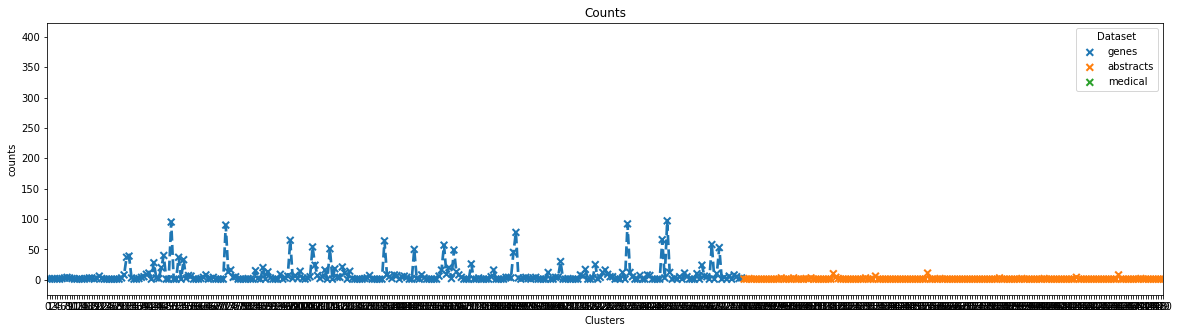

In [75]:
dims = (20, 5)
fig, ax = plt.subplots(figsize=dims)
plt.title('Counts')
sns.pointplot(x=graphcnt[0],y=graphcnt['counts'],hue=graphcnt['Dataset'],data=graphcnt,markers=["x", "x","x"],linestyles=["--", "--","--"])
ax.set_xlabel('Clusters')
plt.xlim(0,450)


(450, 902)

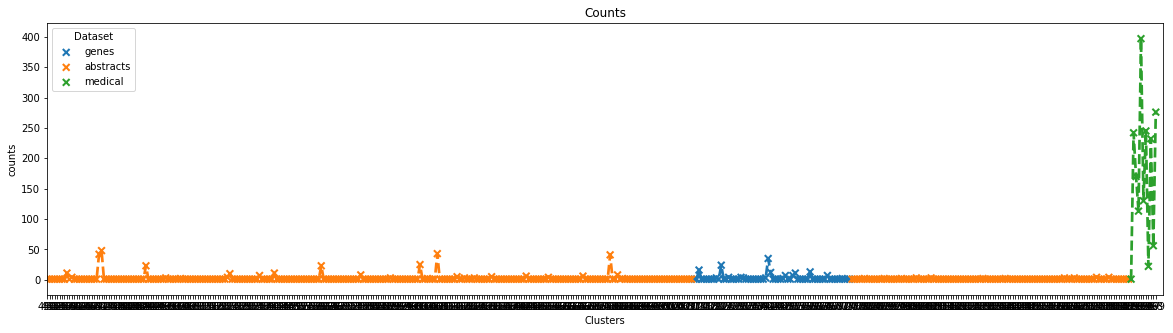

In [76]:
dims = (20, 5)
fig, ax = plt.subplots(figsize=dims)
plt.title('Counts')
sns.pointplot(x=graphcnt[0],y=graphcnt['counts'],hue=graphcnt['Dataset'],label=['genes','abstracts','medical'],data=graphcnt,markers=["x", "x","x"],linestyles=["--", "--","--"])
ax.set_xlabel('Clusters')
plt.xlim(450,902)

It is clear that Affinity Propogation managed to separate all of the datasets. All clusters are formed from one dataset. But that doesn't help me find out which dataset is most similar to the "Abstracts" dataset. Let me explore the Levenshtein distances. 

In [77]:
#analyze Levenshtein distances
np.where(graphit2['Dataset']=='abstracts')

(array([2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389,
        2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400,
        2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411,
        2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422,
        2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433,
        2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444,
        2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455,
        2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466,
        2467, 2468, 2469, 2470, 2471, 2472, 2473, 2474, 2475, 2476, 2477,
        2478, 2479, 2480, 2481, 2482, 2483, 2484, 2485, 2486, 2487, 2488,
        2489, 2490, 2491, 2492, 2493, 2494, 2495, 2496, 2497, 2498, 2499,
        2500, 2501, 2502, 2503, 2504, 2505, 2506, 2507, 2508, 2509, 2510,
        2511, 2512, 2513, 2514, 2515, 2516, 2517, 2518, 2519, 2520, 2521,
        2522, 2523, 2524, 2525, 2526, 

Text(0.5,1,'Nearest Clusters to Abstracts Sample')

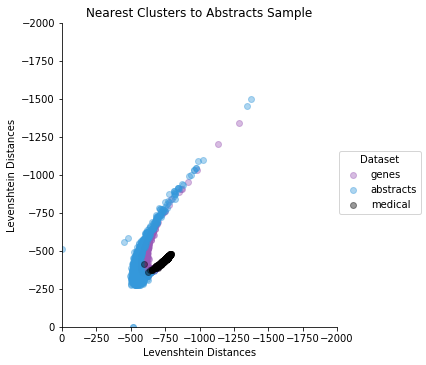

In [78]:
#compare rows/columns with Abstracts
flatui = ["#9b59b6", "#3498db", "k", "#e74c3c", "#34495e", "#2ecc71"]
sns.lmplot(x='z2381',y='z2382',hue='Dataset',data=graphit2,fit_reg=False,palette=flatui,scatter_kws={'alpha': 0.4})
plt.xlabel('Levenshtein Distances')
plt.ylabel('Levenshtein Distances')
plt.xlim(0,-2000)
plt.ylim(0,-2000)
plt.title('Nearest Clusters to Abstracts Sample')

0 is the closest, so abstracts are the most similar to abstracts but many of the genes and a few of the medical clusters are close as well.

In [79]:
np.where(graphit2['Dataset']=='genes')

(array([   0,    1,    2, ..., 3387, 3388, 3389]),)

Text(0.5,1,'Nearest Clusters to Genes Sample')

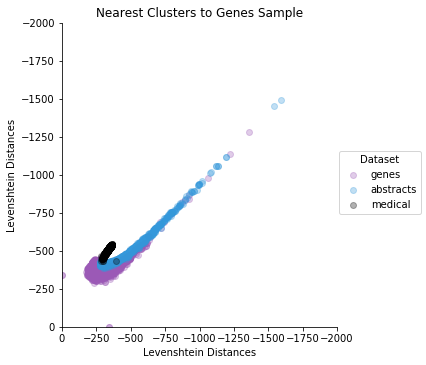

In [80]:
#compare rows/columns with genes
sns.lmplot(x='z1',y='z2',hue='Dataset',data=graphit2,fit_reg=False,palette=flatui,scatter_kws={'alpha': 0.3})
plt.xlabel('Levenshtein Distances')
plt.ylabel('Levenshtein Distances')
plt.xlim(0,-2000)
plt.ylim(0,-2000)
plt.title('Nearest Clusters to Genes Sample')

In [81]:
np.where(graphit2['Dataset']=='medical')

(array([3522, 3523, 3524, ..., 5403, 5404, 5405]),)

Text(0.5,1,'Nearest Clusters to Medical Sample')

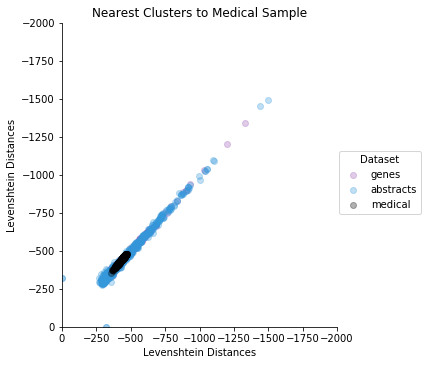

In [82]:
#compare rows/columns with medical
sns.lmplot(x='z3523',y='z3524',hue='Dataset',data=graphit2,fit_reg=False,palette=flatui,scatter_kws={'alpha': 0.3})
plt.xlabel('Levenshtein Distances')
plt.ylabel('Levenshtein Distances')
plt.xlim(0,-2000)
plt.ylim(0,-2000)
plt.title('Nearest Clusters to Medical Sample')

The results for this small subset are encouraging. It looks like some abstracts are more similar to the medical data than medical data, but the genes data is not at all similar to the medical data. The abstracts are similar enough to get clustered in with different datasets but the medical data is not.

Now I'll look at the test set.

In [83]:
#Now analyze test set
test = pd.read_csv('test')
test.head()

,Unnamed: 0,abstract,match,med,symbols,blurb8,tokens,lemmas,lemmastr
0,0,NaN,0.0,0,EGFR,EGFR is epidermal growth factor receptor (hum...,EGFR is epidermal growth factor receptor (hum...,"[' ', 'egfr', 'epidermal', 'growth', 'factor',...",",egfr,epidermal,growth,factor,receptor,(,huma..."
1,1,NaN,0.0,0,VEGFA,VEGFA is vascular endothelial growth factor A...,VEGFA is vascular endothelial growth factor A...,"[' ', 'vegfa', 'vascular', 'endothelial', 'gro...",",vegfa,vascular,endothelial,growth,factor,a,(..."
2,2,NaN,0.0,0,ERBB2,ERBB2 is erb-b2 receptor tyrosine kinase 2 (h...,ERBB2 is erb-b2 receptor tyrosine kinase 2 (h...,"[' ', 'erbb2', '-', 'receptor', 'tyrosine', 'k...",",erbb2,-,receptor,tyrosine,kinase,2,(,human),..."
3,3,NaN,0.0,0,AKT1,AKT1 is AKT serine/threonine kinase 1 (human)...,AKT1 is AKT serine/threonine kinase 1 (human)...,"[' ', 'akt1', 'akt', 'serine', '/', 'threonine...",",akt1,akt,serine,/,threonine,kinase,1,(,human..."
4,4,NaN,0.0,0,BDNF,BDNF is brain derived neurotrophic factor (hu...,BDNF is brain derived neurotrophic factor (hu...,"[' ', 'bdnf', 'brain', 'derive', 'neurotrophic...",",bdnf,brain,derive,neurotrophic,factor,(,huma..."


In [84]:
test['abstracts'] = test['abstract'].fillna(0)
test['meds']=test['med'].fillna(0) 
test['abstracts2'] =  test['abstracts'].apply(lambda x: int(x)*'k')
test['meds2'] =  test['meds'].apply(lambda x: int(x)*'m')
test['sets'] = test['abstracts2']+test['meds2']
test['sets2'] = test['sets'].replace('','g')
test['sets2'].value_counts()
test = test.drop(columns=['abstract','med','sets'])
test.head()

,Unnamed: 0,match,symbols,blurb8,tokens,lemmas,lemmastr,abstracts,meds,abstracts2,meds2,sets2
0,0,0.0,EGFR,EGFR is epidermal growth factor receptor (hum...,EGFR is epidermal growth factor receptor (hum...,"[' ', 'egfr', 'epidermal', 'growth', 'factor',...",",egfr,epidermal,growth,factor,receptor,(,huma...",0.0,0,,,g
1,1,0.0,VEGFA,VEGFA is vascular endothelial growth factor A...,VEGFA is vascular endothelial growth factor A...,"[' ', 'vegfa', 'vascular', 'endothelial', 'gro...",",vegfa,vascular,endothelial,growth,factor,a,(...",0.0,0,,,g
2,2,0.0,ERBB2,ERBB2 is erb-b2 receptor tyrosine kinase 2 (h...,ERBB2 is erb-b2 receptor tyrosine kinase 2 (h...,"[' ', 'erbb2', '-', 'receptor', 'tyrosine', 'k...",",erbb2,-,receptor,tyrosine,kinase,2,(,human),...",0.0,0,,,g
3,3,0.0,AKT1,AKT1 is AKT serine/threonine kinase 1 (human)...,AKT1 is AKT serine/threonine kinase 1 (human)...,"[' ', 'akt1', 'akt', 'serine', '/', 'threonine...",",akt1,akt,serine,/,threonine,kinase,1,(,human...",0.0,0,,,g
4,4,0.0,BDNF,BDNF is brain derived neurotrophic factor (hu...,BDNF is brain derived neurotrophic factor (hu...,"[' ', 'bdnf', 'brain', 'derive', 'neurotrophic...",",bdnf,brain,derive,neurotrophic,factor,(,huma...",0.0,0,,,g


In [126]:
test = test.dropna(subset = ['blurb8'])
test.shape

(1321, 12)

In [86]:
wordst = np.asarray(test['lemmastr'].astype(str))
wordst.shape

(1321,)

In [127]:
#import time
#start = time.time()
words = wordst
lev_simte = -1*np.array([[ed.eval(w1,w2) for w1 in words] for w2 in words])
#end = time.time()
#print(end - start)

In [128]:
lev_simte = pd.DataFrame(lev_simte)
lev_simte.to_csv('levtest2')

In [129]:
levtest2 = pd.read_csv('levtest2')
levtest2.shape

(1321, 1322)

In [130]:
lev_simt2 = np.array(levtest2)
lev_simt3 = lev_simt2[:,1:]

In [131]:
affprop = Aff(affinity="precomputed", damping=.95)
affprop.fit(lev_simt3)
lev_simt3.shape

(1321, 1321)

In [132]:
levtdf=pd.DataFrame(lev_simt3)
levtdf['setid'] = test['sets2']
levtdf['setid'].value_counts()
levtdf.head()

,0,1,2,3,4,5,6,7,8,9,...,1312,1313,1314,1315,1316,1317,1318,1319,1320,setid
0,0,-331,-510,-355,-387,-376,-366,-336,-351,-333,...,-488,-511,-523,-503,-474,-506,-528,-523,-538,g
1,-331,0,-597,-348,-212,-205,-191,-243,-321,-333,...,-298,-318,-327,-312,-287,-314,-332,-326,-340,g
2,-510,-597,0,-512,-642,-636,-628,-575,-558,-510,...,-749,-780,-794,-772,-738,-774,-799,-793,-808,g
3,-355,-348,-512,0,-360,-339,-344,-346,-331,-331,...,-479,-502,-514,-497,-468,-497,-519,-514,-528,g
4,-387,-212,-642,-360,0,-143,-156,-278,-349,-378,...,-217,-233,-241,-226,-214,-227,-244,-241,-252,g


In [133]:
centers=[]
for cluster_id in np.unique(affprop.labels_):
    centers.append([cluster_id,lev_simt3[affprop.cluster_centers_indices_[cluster_id]]])

labels=[]
for cluster_id in affprop.labels_:
    labels.append([cluster_id,lev_simt3[affprop.labels_[cluster_id]]]) 

sets3t = np.asarray(levtdf['setid'])
hue=[]
for cluster_id in np.unique(affprop.labels_):
    hue.append(sets3t[affprop.labels_[cluster_id]]) 

In [134]:
# Pull the number of clusters and cluster assignments for each data point.

cluster_centers_indices = affprop.cluster_centers_indices_
n_clusters_ = len(centers)
labels = labels

print('Estimated number of clusters: {}'.format(n_clusters_))

Estimated number of clusters: 204


In [135]:

for cluster_id in np.unique(affprop.labels_):
    
    exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
    cluster = words[np.nonzero(affprop.labels_==cluster_id)]
    clusters = cluster
    cluster_str = '|||'.join(str(x) for x in clusters)
    if len(clusters)>3:
        print(" - *%s:* %s" % (exemplar, cluster_str))

 - * ,hla,-,a,major,histocompatibility,complex,,,class,i,,,a,(,human),also,hlaa,,,-PRON-,hla,class,-PRON-,histocompatibility,antigen,,,a-1,alpha,chain,;,low,quality,protein,:,hla,class,-PRON-,histocompatibility,antigen,,,a-1,alpha,chain,;,mhc,class,-PRON-,antigen,hla,-,a,heavy,chain,;,leukocyte,antigen,class,-PRON-,-,a,,,chromosome,:,6,;,location,:,6p22.1,annotation,:,chromosome,6,nc_000006.12,(,29942470,..,29945884),mim,:,142800:*  ,hla,-,a,major,histocompatibility,complex,,,class,i,,,a,(,human),also,hlaa,,,-PRON-,hla,class,-PRON-,histocompatibility,antigen,,,a-1,alpha,chain,;,low,quality,protein,:,hla,class,-PRON-,histocompatibility,antigen,,,a-1,alpha,chain,;,mhc,class,-PRON-,antigen,hla,-,a,heavy,chain,;,leukocyte,antigen,class,-PRON-,-,a,,,chromosome,:,6,;,location,:,6p22.1,annotation,:,chromosome,6,nc_000006.12,(,29942470,..,29945884),mim,:,142800||| ,hla,-,g,major,histocompatibility,complex,,,class,i,,,g,(,human),also,mhc,-,g,,,-PRON-,hla,class,-PRON-,histocompatibility,antigen,

In [136]:
exemplars=[]

clusters=[]
for cluster_id in np.unique(affprop.labels_):
    
    exemplars.append([cluster_id,affprop.cluster_centers_indices_[cluster_id]])
    clusters.append([cluster_id,lev_simt3[np.nonzero(affprop.labels_==cluster_id)]])

clustersdf = pd.DataFrame(clusters)
exemplarsdf = pd.DataFrame(exemplars)

closet=[]
for c,i in enumerate(clustersdf.iloc[:,1],0):
    for x in clustersdf.iloc[c,1]:
        closet.append([clustersdf.iloc[c,0],x])

closetdf = pd.DataFrame(closet)
closetdf.shape

(1321, 2)

In [137]:
graphitt = closetdf.merge(exemplarsdf,how='left', on =0)
len(graphitt['1_x'][0])

1321

In [138]:
graphitt['Dataset']=np.asarray(levtdf['setid'])[graphitt['1_y']]
graphitt = graphitt.dropna()

In [139]:
graphitt['setids']=graphitt['Dataset'].apply(lambda x: x.replace('g','genes'))
graphitt['setids']=graphitt['setids'].apply(lambda x: x.replace('k','abstracts'))
graphitt['Dataset']=graphitt['setids'].apply(lambda x: x.replace('m','medical'))
graphitt['Dataset'].value_counts()


genes        618
medical      403
abstracts    208
Name: Dataset, dtype: int64

In [140]:
graphitt2 = pd.DataFrame(graphitt)

In [143]:
names=[]
for i in range(1,1322):
    names.append('z'+ str(i))

In [144]:
graphitt2[names] = pd.DataFrame(graphitt2['1_x'].values.tolist(), index = graphitt2.index)

graphitt2['counts']=graphitt2[0]
graphcntt = graphitt2.groupby([0,'Dataset'])['counts'].size().reset_index()
graphcntt.head()

,0,Dataset,counts
0,0,genes,1
1,1,genes,3
2,2,genes,9
3,3,genes,1
4,4,genes,1


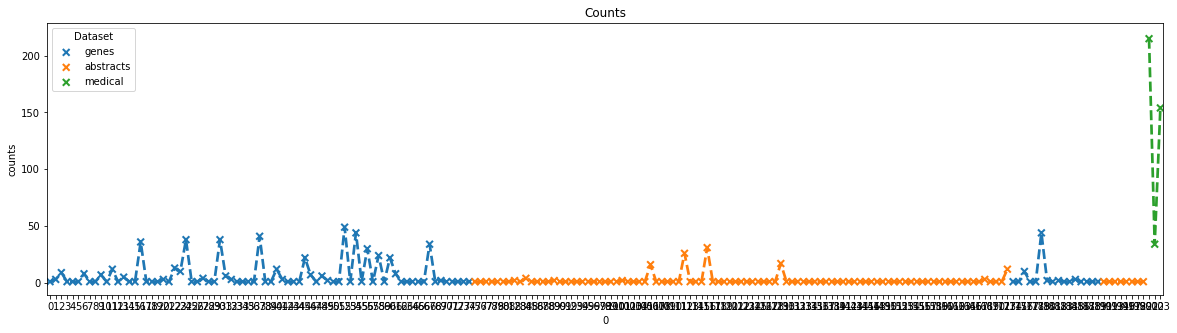

In [145]:
dims = (20, 5)
fig, ax = plt.subplots(figsize=dims)
plt.title('Counts')
sns.pointplot(x=graphcntt[0],y=graphcntt['counts'],hue=graphcntt['Dataset'],data=graphcntt,markers=["x", "x","x"],linestyles=["--", "--","--"])


Similar results. All the datasets are separated into clusters and all the medical data is bunched up into a few clusters.

In [146]:
np.where(graphitt2['Dataset']=='abstracts')

(array([546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558,
        559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571,
        572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584,
        585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597,
        598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610,
        611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623,
        624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636,
        637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649,
        650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662,
        663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675,
        676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688,
        689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701,
        702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 714,
        715, 716, 717, 718, 719, 720, 721, 722, 723

Text(0.5,1,'Nearest Clusters to Abstracts Sample')

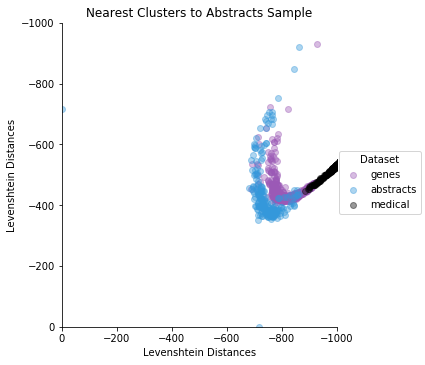

In [147]:
#compare rows/columns with Abstracts
flatui = ["#9b59b6", "#3498db", "k", "#e74c3c", "#34495e", "#2ecc71"]

sns.lmplot(x='z570',y='z571',hue='Dataset',data=graphitt2,fit_reg=False,palette=flatui,scatter_kws={'alpha': 0.4})
plt.xlabel('Levenshtein Distances')
plt.ylabel('Levenshtein Distances')
plt.xlim(0,-1000)
plt.ylim(0,-1000)

plt.title('Nearest Clusters to Abstracts Sample')

In [148]:
np.where(graphitt2['Dataset']=='genes')

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

Text(0.5,1,'Nearest Clusters to Genes Sample')

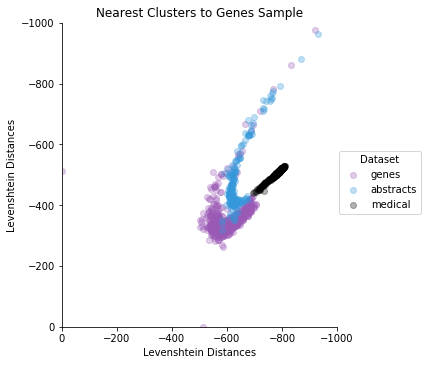

In [149]:
#compare rows/columns with genes
sns.lmplot(x='z3',y='z4',hue='Dataset',data=graphitt2,fit_reg=False,palette=flatui,scatter_kws={'alpha': 0.3})
plt.xlabel('Levenshtein Distances')
plt.ylabel('Levenshtein Distances')
plt.xlim(0,-1000)
plt.ylim(0,-1000)

plt.title('Nearest Clusters to Genes Sample')

In [150]:
np.where(graphitt2['Dataset']=='medical')

(array([ 826,  827,  828,  829,  830,  831,  832,  833,  834,  835,  836,
         837,  838,  839,  840,  841,  842,  843,  844,  845,  846,  847,
         848,  849,  850,  851,  852,  853,  854,  855,  856,  857,  858,
         859,  860,  861,  862,  863,  864,  865,  866,  867,  868,  869,
         870,  871,  872,  873,  874,  875,  876,  877,  878,  879,  880,
         881,  882,  883,  884,  885,  886,  887,  888,  889,  890,  891,
         892,  893,  894,  895,  896,  897,  898,  899,  900,  901,  902,
         903,  904,  905,  906,  907,  908,  909,  910,  911,  912,  913,
         914,  915,  916,  917,  918,  919,  920,  921,  922,  923,  924,
         925,  926,  927,  928,  929,  930,  931,  932,  933,  934,  935,
         936,  937,  938,  939,  940,  941,  942,  943,  944,  945,  946,
         947,  948,  949,  950,  951,  952,  953,  954,  955,  956,  957,
         958,  959,  960,  961,  962,  963,  964,  965,  966,  967,  968,
         969,  970,  971,  972,  973, 

Text(0.5,1,'Nearest Clusters to Medical Sample')

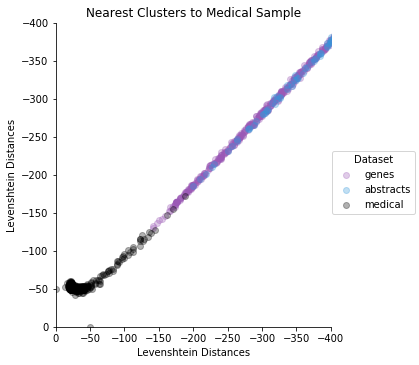

In [151]:
#compare rows/columns with medical
sns.lmplot(x='z874',y='z875',hue='Dataset',data=graphitt2,fit_reg=False,palette=flatui,scatter_kws={'alpha': 0.3})
plt.xlabel('Levenshtein Distances')
plt.ylabel('Levenshtein Distances')
plt.xlim(0,-400)
plt.ylim(0,-400)
plt.title('Nearest Clusters to Medical Sample')

Even though the test is much heavier with medical data, Levenshtein results look similar. It looks like the medical data is the only data that is not similar to the genes data.

I should get better results when I use Spectral Clustering on the Levenshtein distances because I can choose the number of clusters, which means I can force the model to cluster the abstracts with one of the two other datasets.